## Example 1: Regular Domain
This notebook present an example of FDSS with the function proposed by Helwig and Ma (2016) [[1]](#bigspline):
$$
    \eta_\theta(x_1,x_2)=x_1+x_2-1+\dfrac{1}{4}[\sin(2\theta\pi x_1)+\cos(2\theta\pi x_2)+2\sin(2\pi(x_1+x_2))].
$$


**Reference**

<a id='bigspline'></a>
[1.](https://scholar.google.com/scholar_url?url=https://arxiv.org/abs/1602.05208&hl=zh-TW&sa=T&oi=gsb&ct=res&cd=0&d=12682735654083085400&ei=B0bqZpvdMMqI6rQP5dPz6Q4&scisig=AFWwaebUZUacy2LxfyNqOrLCwMea) Helwig NE, Ma P (2016) Smoothing spline ANOVA for super-large samples: Scalable computation
via rounding parameters. Statistics and Its Interface 9:433–444

In [1]:
import torch
from fdss import FDSS, gen_grid
from utils import gen_eta_data, eta
import matplotlib.pyplot as plt
from matplotlib import  colors

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"

### Generating data and grid
+ gen_eta_data(N, k, *, engine='p', sde=.1, seed=None): generate data
  + `N`: number of sample
  + `k`: level of smoothness $\theta$
  + `engine`('r', 'p' or 'python'): engine can only be 'r'(for r), 'p','python' (for python)

In [2]:
N, k = 1e6, 3
r = .01

X, y, yt = gen_eta_data(N, k, engine = 'p')
print("Data shape: ", X.shape, y.shape, yt.shape)

lim = [0,1]
X_grid = gen_grid(lim, lim, r=r)
print("Grid shape: ", X_grid.shape)

Data shape:  torch.Size([1000000, 2]) torch.Size([1000000]) torch.Size([1000000])
Grid shape:  torch.Size([101, 101, 2])


In [3]:
model = FDSS(X_grid, device=device)
model.fit(X, y, print_every=True)
print('sp = ', model.best_sp.item(), f" ( iter = {model.n_iter})")

/home/luhung/.venv/torch/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


lam = 1.39E-19, mse = 0.01035 (-inf), iter = 144
lam = 3.90E-17, mse = 0.01035 (0.000), iter = 13
lam = 1.09E-14, mse = 0.01035 (0.000), iter = 4
lam = 3.06E-12, mse = 0.01035 (0.000), iter = 5
lam = 8.57E-10, mse = 0.01035 (0.000), iter = 1
lam = 2.40E-07, mse = 0.01035 (0.000), iter = 1
lam = 6.72E-05, mse = 0.01035 (0.000), iter = 1
lam = 1.88E-02, mse = 0.01025 (-0.000), iter = 68
lam = 5.27E+00, mse = 0.05318 (0.043), iter = 200
lam = 1.48E+03, mse = 0.05574 (0.045), iter = 200
sp =  0.01881742849946022  ( iter = 34)


In [4]:
_, mse = model.transform(X, y, eval_func='mse')
print(f"mse = {mse:.2E}")

mse = 1.03E-02


In [5]:
xg, zg = X_grid.unbind(-1)
trug = eta(xg, zg, k=k)
yg, ise = model.transform(X_grid.reshape(-1,2), trug.reshape(-1))
yg = yg.reshape(model.Y_grid.shape)
print(f"ise = {ise:.2E}")

ise = 1.83E-05


Text(0.5, 1.0, 'sp = 1.88E-02, ise = 1.83E-05')

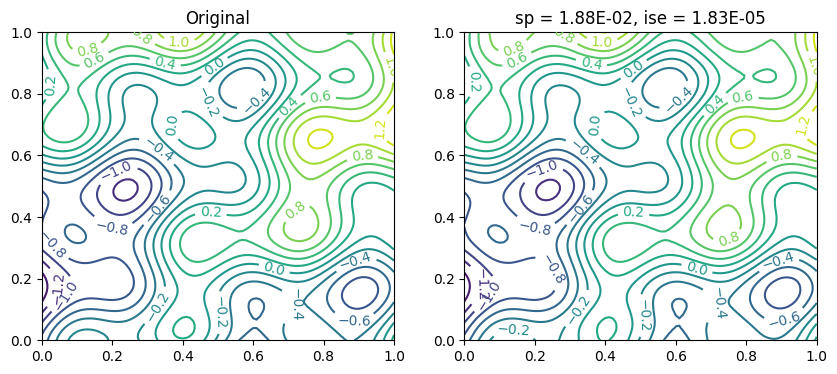

In [6]:
plt.figure(figsize=(10, 4))
level = 15

ax = plt.subplot(1, 2, 1)
C = ax.contour(xg,zg,trug, levels = level)
ax.clabel(C, inline=True, fontsize=10)
ax.set_title(f"Original")

ax = plt.subplot(1, 2, 2)
C = ax.contour(xg,zg, yg.cpu(), levels = level)
ax.clabel(C, inline=True, fontsize=10)
ax.set_title(f"sp = {model.best_sp.item():.2E}, ise = {ise:.2E}")